In [1]:
cd ~/work/waroncars

/media/wintermute/work/waroncars


In [2]:
plt = plotter()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
import kalman

In [4]:
def norm_sum(x):
    s = x.cumsum()
    return s/s[-1]

In [5]:
def make_hline(ax, y=0):
    ax.hlines(y, *ax.get_xlim(), linestyle='--', linewidth=1, color='black')

In [6]:
def std_diag(Σ):
    return np.sqrt(np.diag(Σ))

In [7]:
def gen_kalman(kal, time, path):
    for i, (t, z) in enumerate(zip(time, path)):
        if i == 0:
            x, P = kal.start(z)
            t0 = t
        else:
            dt = t - t0
            yield kal.position(x, P, dt=dt)
            x, P = kal.update(x, P, z, dt=dt)
            t0 = t

In [8]:
names0 = ['x', 'y', 'w', 'h']
names = names0 + [f'v{c}' for c in names0]
namesσ0 = [f'σ{c}' for c in names0]
namesσ = [f'σ{c}' for c in names]
marker = dict(marker='o', markersize=3)

## Generate Path

In [53]:
# path params
N = 100
zϵ = np.array([0.1, 0.1, 0.01, 0.01])
z0 = np.array([0.1, 0.2, 0.1, 0.1])
z1 = np.array([0.9, 0.5, 0.12, 0.08])

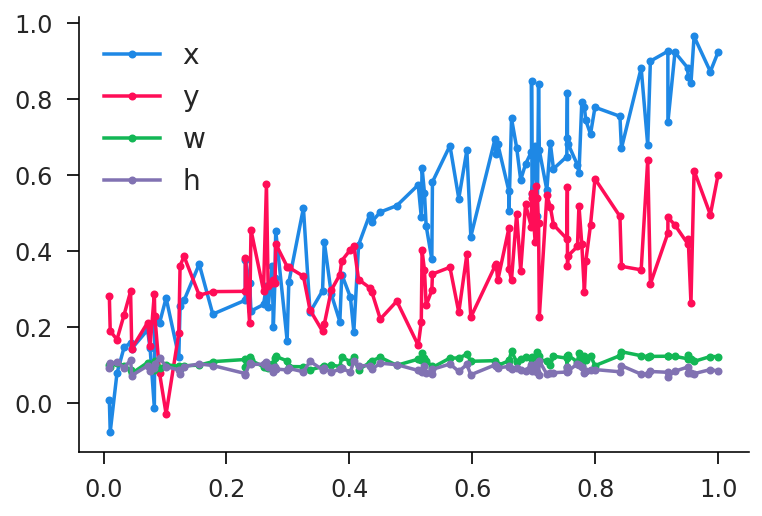

In [54]:
# generate path
# t_path = np.linspace(0, 1, N)
t_path = norm_sum(np.random.exponential(1/N, size=N))
z_path = (1-t_path[:, None])*z0[None, :] + t_path[:, None]*z1[None, :]
z_obs = z_path + zϵ[None, :]*np.random.randn(N, 4)
df_obs = pd.DataFrame(z_obs, columns=names0, index=t_path)
df_obs.plot(**marker);

## Run Filter

In [80]:
# kalman setup
nd = 4
σx = np.array([0.05, 0.05, 0.02, 0.02])
σv = np.array([0.5, 0.5, 0.5, 0.5])
k = kalman.KalmanTracker(nd, σx, σv)

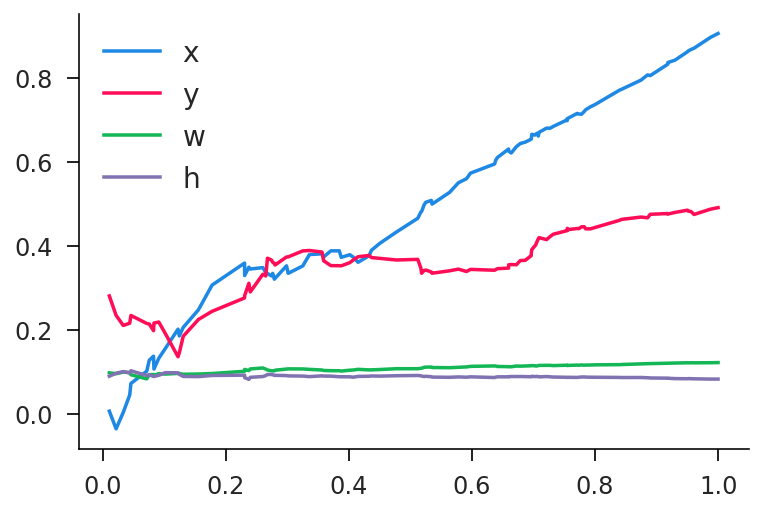

In [81]:
x_list, P_list = zip(*gen_kalman(k, t_path, z_obs))
x_pred = np.vstack(x_list)
P_pred = np.vstack([std_diag(P) for P in P_list])
df_pred = pd.DataFrame(x_pred, columns=names0, index=t_path[1:])
df_sigma = pd.DataFrame(P_pred, columns=names0, index=t_path[1:])
df_pred.plot();

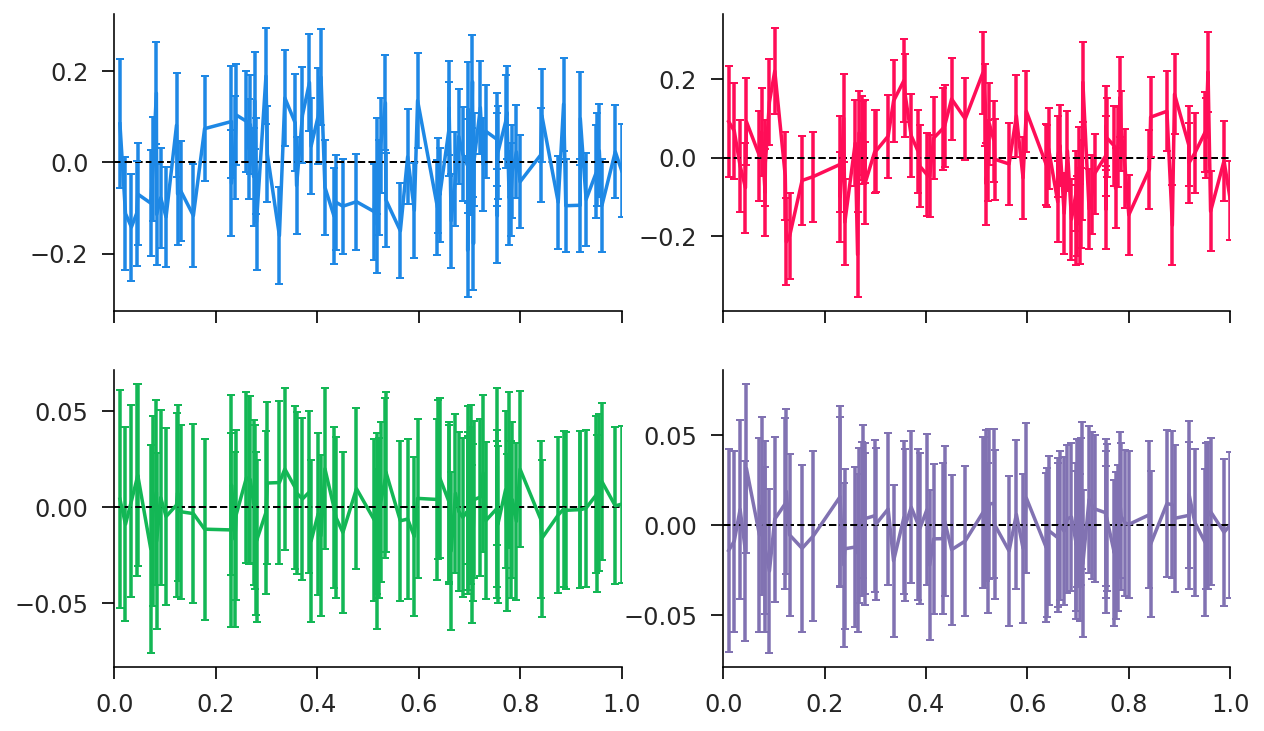

In [82]:
df_err = (df_pred[names0] - df_obs).dropna()
yerr = 2*df_sigma[names0].values.T
axs = df_err.plot(yerr=yerr, subplots=True, layout=(2, 2), figsize=(10, 6), legend=False, capsize=2)
for ax in axs.flatten():
    ax.set_xlim(0, 1)
    make_hline(ax)

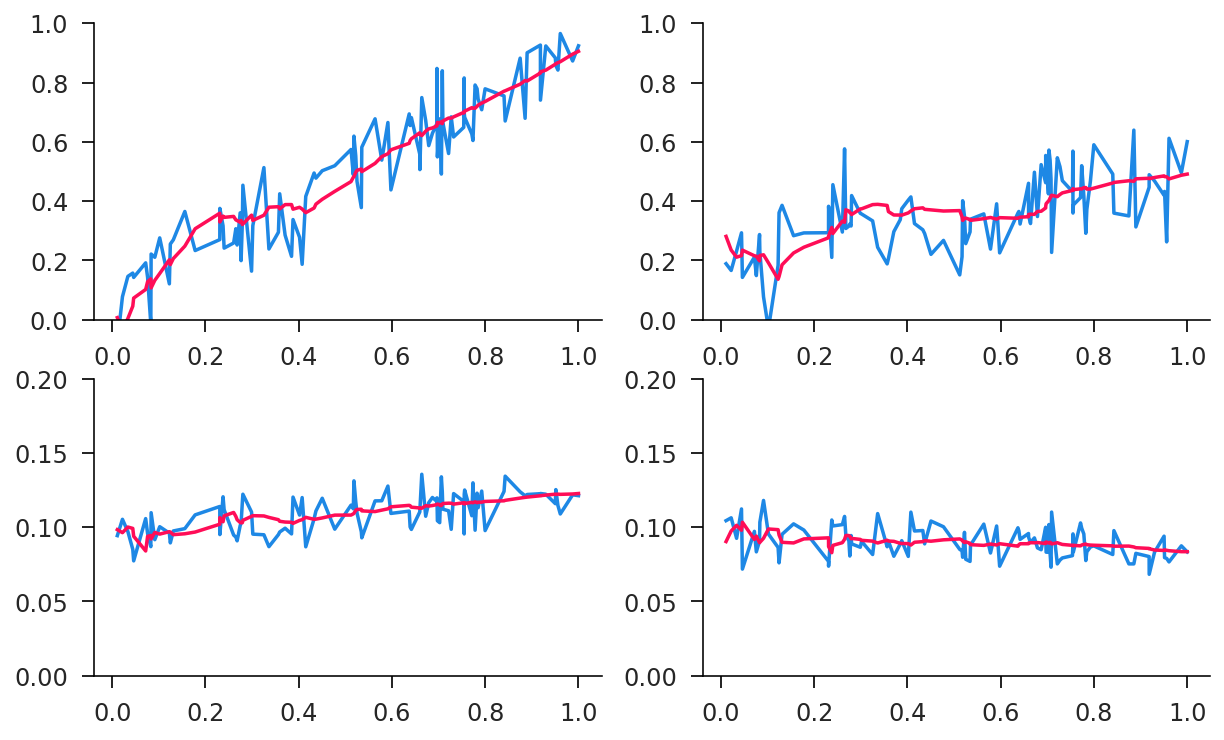

In [83]:
df_joint = pd.concat([
    df_obs.add_suffix('_obs'),
    df_pred[names0].add_suffix('_pred'),
], axis=1).dropna()
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
for c, ax in zip(names0, axs.flatten()):
    df_joint[[f'{c}_obs', f'{c}_pred']].plot(ax=ax, legend=False)
axs[0, 0].set_ylim(0, 1); axs[0, 1].set_ylim(0, 1);
axs[1, 0].set_ylim(0, 0.2); axs[1, 1].set_ylim(0, 0.2);

## Tracking

In [84]:
from ipywidgets import interact, interactive
import ipywidgets as widgets
from scipy.stats import chi2
import matplotlib as mpl

In [85]:
xmax, ymax = 1.2, 0.8
gridx = np.linspace(0, xmax, 150)
gridy = np.linspace(0, ymax, 100)
grid2x, grid2y = map(np.transpose, np.meshgrid(gridx, gridy))
grid2 = np.stack([grid2x, grid2y], axis=-1)

In [86]:
def vector_mahalanobis(x, P):
    Pi = kalman.robust_inverse(P)
    dz = x - grid2
    e = np.einsum('ijk,kk,ijk->ij', dz, Pi, dz)
    q = chi2.cdf(e, 4)
    return q

In [87]:
def display_error(i, stat='position'):
    if stat == 'position':
        x = x_pred[i,:2]
        P = P_list[i][:2,:2]
        xm, ym = xmax, ymax
    elif stat == 'size':
        x = x_pred[i,2:4]
        P = P_list[i][2:4,2:4]
        xm, ym = 0.2, 0.2
    e = vector_mahalanobis(x, P)
    fig, ax = plt.subplots()
    cont = ax.contour(grid2x, grid2y, e, extent=(0, xm, ym, 0))
    ax.clabel(cont, cont.levels)
    plt.show()

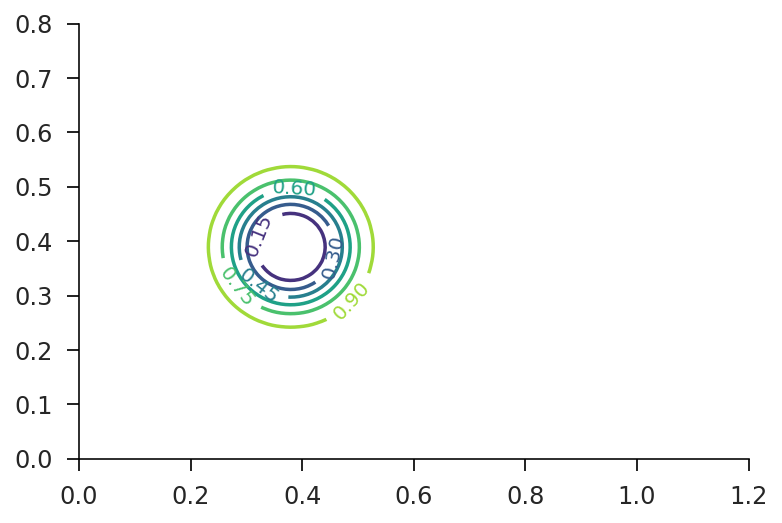

In [88]:
display_error(30)

In [90]:
i1 = widgets.IntSlider(min=0, max=N-2, step=1)
interact(lambda i: display_error(i, stat='size'), i=i1);

interactive(children=(IntSlider(value=0, description='i', max=98), Output()), _dom_classes=('widget-interact',…